# Segmentation task using U-Net
Version of the scientific paper:   
O. Ronneberger and P.Fischer and T. Brox, 2015, U-Net: Convolutional Networks for Biomedical Image Segmentation, Medical Image Computing and Computer-Assisted Intervention (MICCAI). 

**Our goal is to segment the food elements in the images from the Tray Dataset.**  

In [1]:
import torch
import torch.nn as nn
import torchmetrics as met
import torchvision.transforms.functional as functional

import pickle as pkl
import numpy as np

## Data

The data come from the Tray Dataset available on Kaggle. **PUT REFERENCES**  
Statistical analysis on the train subset.   

During our analysis of the images we find out that the intensity of the pixels isn't following a normal distribution and has a very long "tail" in each channel. However, the distribution seems similar for each channels. This might be a problem for the segmentation task of the pixels. We'll have to preprocess the images with appropriate transformations to overcome this.

As we can see from the various plot, the frequency of labels in images varies very much. Even some classes aren't represetend at all in the train dataset: straw, beef, meetball, ... Those classes have to be removed from the dataset in order to save up the compute ressources and considering the **no-free lunch theorem (give the reference here)**.  
For the other classes, we observe that the repartition of the first three classes (backgroung, tray, clutlery) is homogeneous but they are far more represented in the dataset's labels than any other one. Moreover, some other classes are absent from some images and present a normal distribution of the number of pixels in the rest.    
This may cause a problem when using the cross entropy loss function. **tell mathematically why here**.   
  
From our analysis, we'll delete the following classes from our considerations: from, straw, meatball, beef, carot, celery, water.   
Moreover, to facilitate the problem, we'll try to predict the first 3 classes to start: background, tray, cutlery. The strategy we'd like to apply is to determine the frequency by considering only those three and maybe apply weights on the loss to correct the unbalanced representation.  

One of the problems we have to deal with is by which class the rest of the set of the class should be replace?
Because the sum of all of the pixels labelled with one of the rest of the classes represents a fraction of almost 10% of the total of pixels, we'll create a class tagged as 'undetermined'.  



In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import random

In [3]:
class MaskPILToTensor:
    """
        Class to transform Masks (targets) into a Tensor without the unwanted scaling of ToTensor
    """
    def __call__(self, mask):
        mask = functional.pil_to_tensor(mask)
        return mask
    
class MaskTensorToPIL:
    """
        Inverse transformation of MaskToPIL
    """
    def __call__(self, mask):
        mask = functional.to_pil_image(mask)
        return mask

In [4]:
class TrayDataset(Dataset):

    def __init__(self, annotations_file_path, _img_dir_path, _label_dir_path,
                 scal_norm_transform=None, random_rot_transform=None, mask_transform=MaskPILToTensor(),
                 data_augmentation=False, 
                 adapt_to_task=False, first_class_idx_of_the_rest=None):
        print("Initialization of TrayDataset...")
        super(TrayDataset, self).__init__()
        self.classes_dataframe    = pd.read_csv(annotations_file_path)
        self.img_dir_path         = _img_dir_path
        self.label_dir_path       = _label_dir_path
        self.scal_norm_transform  = scal_norm_transform
        self.random_rot_transform = random_rot_transform
        self.mask_transform       = mask_transform
        self.data_augmentation    = data_augmentation

        self.img_filenames   = sorted(os.listdir(self.img_dir_path))
        self.label_filenames = sorted(os.listdir(self.label_dir_path))

        # adaptation of the labels and the classes dataframe to the task
        if adapt_to_task and first_class_idx_of_the_rest is not None:
            print("Adapting the labels and dataframe to task...")
            self.first_class_idx_of_the_rest = first_class_idx_of_the_rest
            new_label_dir_path = self.__adapt_labels_and_dataframe_to_task()
            self.label_dir_path = new_label_dir_path
        else:
            self.first_class_idx_of_the_rest = None
            
        print("Init TrayDataset done.")


    def __len__(self):
        return len(os.listdir(self.img_dir_path))
    

    def __adapt_labels_and_dataframe_to_task(self):
        """
            Modify the ground truth labels and the classes dataframe by regrouping all the classes which index
            is above or equal to first_index_of_the_rest under one big class ('undetermined')
            -> must be private and use in the init
        """
        # modify the mask 
        for label_idx in range(len(os.listdir(self.label_dir_path))):
            # label is a tensor thanks to __getitem__
            _, label = self.__getitem__(label_idx)
            # replace all the class with index > first_class_idx_of_the_rest by first_class_idx_of_the_rest
            label[label > self.first_class_idx_of_the_rest] = self.first_class_idx_of_the_rest 
            # save label in new dir
            if label_idx == 0:
                new_dir_path = self.__save_modified_labels(label_idx, label)
            else:
                _ = self.__save_modified_labels(label_idx, label)

        # drop rows of the rest of the class
        self.classes_dataframe.drop(self.classes_dataframe[self.classes_dataframe['_id'] >= self.first_class_idx_of_the_rest].index, 
                                    inplace=True
                                    )
        # create a new row that regroups all the dropped classes into one undetermined class
        new_class_row = pd.DataFrame({'_id': self.first_class_idx_of_the_rest, '_class': 'undeterminded', '_name': 'undetermined'}, 
                                     index=[len(self.classes_dataframe)]
                                     )
        self.classes_dataframe = pd.concat([self.classes_dataframe.loc[:], new_class_row])
        print("Adapt TrayDataset to the task done.")

        return new_dir_path


    def __save_modified_labels(self, label_idx, label):
        """
            Save the labels as PNG images to the specified directory.

            Args:
                labels (list of numpy.ndarray): The modified labels to save.
                directory (str): The directory to save the labels to.
        """
        # inverse transform applied on labels
        transform = MaskTensorToPIL()
        # create the directory to store the modified labels if it doesn't exist
        new_yTrain_dir_name = "./TrayDataset/TrayDataset/yTrain_adapted_to_the_task"
        if not os.path.exists(new_yTrain_dir_name):
            os.makedirs(new_yTrain_dir_name)

        # save label as PNG image
        label_png = transform(label)
        label_name = self.label_filenames[label_idx]
        file_path = os.path.join(new_yTrain_dir_name, f'{label_name}')
        label_png.save(file_path)
        
        return new_yTrain_dir_name


    def transform_fn(self, image, label):
        """
            Transforms pipeline
        """
        # data augmentation
        if self.data_augmentation:
            # horizontal flipping
            if random.random() > 0.5:
                image = transforms.functional.hflip(image)
                label = transforms.functional.hflip(label)
            # vertical flipping
            if random.random() > 0.5:
                image = transforms.functional.vflip(image)
                label = transforms.functional.vflip(label)

        # random rotation (concatenation in order to obtain the same rotation)
        # at this point image and label are still in (height, width, channel) layout
        if self.random_rot_transform is not None:
            concat_img_label   = torch.cat((image, label), 0)
            transformed_concat = transforms.RandomRotation(10)(concat_img_label)

            image = transformed_concat[0]
            label = transformed_concat[1]

        # scal and normalization
        if self.scal_norm_transform is not None:
            image = self.scal_norm_transform(image)

        if self.mask_transform is not None:
            label = self.mask_transform(label)

        return image, label


    def __getitem__(self, img_idx):
        img_name   = self.img_filenames[img_idx]
        label_name = self.label_filenames[img_idx]

        image_path = os.path.join(self.img_dir_path, img_name)
        image      = Image.open(image_path)
        label_path = os.path.join(self.label_dir_path, label_name)
        label      = Image.open(label_path)
        
        image, label = self.transform_fn(image, label)

        return image, label
    

    def get_mean_std_images(self):
        """
            Function to obtain the mean and std of a dataset for each channels 
            after a ToTensor transform with scaling
        """
        images_tens = []
        for image_idx in range(len(os.listdir(self.img_dir_path))):
            image, _ = self.__getitem__(image_idx)
            images_tens.append(image)
        images_tens = torch.stack(images_tens)

        mean = torch.mean(images_tens, dim=(0,2,3))
        std = torch.std(images_tens, dim=(0,2,3))

        return [mean[i].item() for i in range(3)], [std[i].item() for i in range(3)]
    

    def get_classes_frequency(self):
        """
            Used to obtain the frequency of each classes in the ground truth labels after all the transformations have been applied
            on the labels 
            (Random flips doesn't change the representation of classes in the set)
            (except doesn't suit Random Rotation)
        """
        classes_frequency = torch.zeros(len(self.classes_dataframe))

        n_labels          = len(os.listdir(self.label_dir_path))
        for label_idx in range(n_labels):
            _, label = self.__getitem__(label_idx)
            for class_idx in range(self.first_class_idx_of_the_rest + 1):
                classes_frequency[class_idx] += torch.count_nonzero(label == class_idx).item()

        return classes_frequency / classes_frequency.sum()

In [5]:
def get_dataloader(dataset, **kwargs) -> DataLoader:
     
    if dataset is None:
        raise ValueError("Dataset object must not be None.")

    if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
    else:
        _batch_size = 32

    if 'shuffle' in kwargs:
        _shuffle = kwargs.get('shuffle')
    else:
        _shuffle = True

    return DataLoader(dataset, shuffle=_shuffle, batch_size=_batch_size)

#### Stats and test

In [6]:
# annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
# train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
# train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'

# train_dataset            = TrayDataset(annotations_file_path, 
#                                        train_dataset_img_path, train_dataset_label_path
#                                        )

# # before any modification
# classes = pd.read_csv(annotations_file_path)
# print(classes.head())
# print("Number of classes:", len(classes))

# # the panda dataframe of TrayDataset
# train_dataset.classes_dataframe 

In [7]:
# images
#train_dataset[0][0]

In [8]:
# labels
#train_dataset[0][1]

In [9]:
def dump_dataset_in_pickle(dataset, save_path):
    images = []
    labels = []
    for image, label in dataset:
        images.append(np.array(image))
        labels.append(np.array(label))
    images_path = save_path + 'images.pkl'
    labels_path = save_path + 'labels.pkl'
    with open(images_path, "wb") as images_file, open(labels_path, "wb") as labels_file:
        pkl.dump(images, images_file)
        pkl.dump(labels, labels_file)


def get_stats_on_raw_numpy_data(images_pkl_path, labels_pkl_path, classes):
    """
        Function that regroups the statistics and various plots necessary to uexplore the properties of the dataset
    """
    
    with open(images_pkl_path, 'rb') as images_file, open(labels_pkl_path, "rb") as labels_file:
        images = pkl.load(images_file)
        labels = pkl.load(labels_file)

    print("\nTrain dataset information\n")
    print(f"Number of images:\t{len(images)}")
    print(f"Images' shape:\t\t{images[0].shape}")
    print(f"Images' dytpe:\t\t{images[0].dtype}")
    print(f"Labels' shape:\t\t{labels[0].shape}")
    print(f"Labels' dytpe:\t\t{labels[0].dtype}")
    print(f"Number of classes:\t{len(classes)}")


    imgs_array = np.array(images)

    # compute mean values of images for each channel    
    mean_images_red = np.mean(imgs_array[:,:,:,0]) 
    mean_images_green = np.mean(imgs_array[:,:,1]) 
    mean_images_blue = np.mean(imgs_array[:,:,2]) 
    print(f"Mean of RGB values:\tred = {mean_images_red:.1f}, green = {mean_images_green:.1f}, blue = {mean_images_blue:.1f}")

    median_images_red = np.median(imgs_array[:,:,0]) 
    median_images_green = np.median(imgs_array[:,:,1]) 
    median_images_blue = np.median(imgs_array[:,:,2]) 
    print(f"Median of RGB values:\tred = {median_images_red:.1f}, green = {median_images_green:.1f}, blue = {median_images_blue:.1f}")

    # min = 0 --> black
    min_images_red = np.min(imgs_array[:,:,:,0]) 
    min_images_green = np.min(imgs_array[:,:,1]) 
    min_images_blue = np.min(imgs_array[:,:,2]) 
    print(f"Min of RGB values:\tred = {min_images_red:.1f}, green = {min_images_green:.1f}, blue = {min_images_blue:.1f}")

    max_images_red = np.max(imgs_array[:,:,:,0]) 
    max_images_green = np.max(imgs_array[:,:,1]) 
    max_images_blue = np.max(imgs_array[:,:,2]) 
    print(f"Max of RGB values:\tred = {max_images_red:.1f}, green = {max_images_green:.1f}, blue = {max_images_blue:.1f}")

    std_images_red = np.std(imgs_array[:,:,0]) 
    std_images_green = np.std(imgs_array[:,:,1]) 
    std_images_blue = np.std(imgs_array[:,:,2]) 
    print(f"Std of RGB values:\tred = {std_images_red:.1f}, green = {std_images_green:.1f}, blue = {std_images_blue:.1f}")

    # fig to plot the repartition of pixels intensity in all the images
    fig1 = plt.figure(figsize=(20,10))
    channels_label = ["R channel", "G channel", "B channel"]
    for channel in range(3):
        ax = plt.subplot(2,2,channel+1)
        pix_intensities = np.zeros(256)
        for intensity_value in range(256):
            pix_intensities[intensity_value] += np.count_nonzero(imgs_array[:,:,channel] == intensity_value)
            ax.scatter(intensity_value, pix_intensities[intensity_value])
            ax.set_title(channels_label[channel])
        ax.set_xlabel("Intensity of pixels")
        ax.set_ylabel("Number of pixels")
        ax.grid()
    plt.show()

    classes_frequency = np.zeros((len(images), len(classes)))
    image_idx = 0

    for label in labels:
        for class_idx in range(42):
            classes_frequency[image_idx,class_idx] += np.count_nonzero(label == class_idx) 
        image_idx += 1
    global_class_freq = np.sum(classes_frequency, axis=0) / (labels[0].shape[0] * labels[0].shape[1] * labels[0].shape[2] * len(images) )
    
    # plot the frequency of the classes
    fig2, axs = plt.subplots(1,1)
    fig2.set_figheight(5)
    fig2.set_figwidth(10)
    fig2.suptitle("Frequency of classes")
    axs.scatter(np.arange(1,44), global_class_freq)
    axs.set_xticks(np.arange(1,44,2))
    axs.set_xlabel("Index of class")
    axs.set_title("Global frequency of each classes")
    plt.grid()
    plt.show()

    fig3 = plt.figure(figsize=(22,33))
    fig3.suptitle(f"Repartition of classes in the {len(images)} images of the dataset")
    for class_idx in range(len(classes)):
        ax = plt.subplot(9,5,class_idx+1)
        ax.hist(classes_frequency[:,class_idx] )
        # convert y ticks to pourcentage of images
        y_ticks = ax.get_yticks()
        yticks = [int((tick / 1241) * 100) for tick in y_ticks]
        if int(yticks[-1]) > 100:
            yticks[-1] = 100
        ax.set_yticklabels(yticks)
        ax.set_ylabel('(%) of images')
        ax.set_title(f"class {classes['_class'].iloc[class_idx]}")
        ax.grid()
    plt.show()

    return global_class_freq

def get_mean_std_ToTensor(images_pkl_path, labels_pkl_path, plot=True):
    """
        Function to obtain the mean and std of a dataset for each channels 
        after a ToTensor transform with scaling
    """
    with open(images_pkl_path, 'rb') as images_file:
        images = pkl.load(images_file)

    transform = transforms.ToTensor()

    images_tens = []
    for image, label in images:
        images_tens.append(transform(image))
    images_tens = torch.stack(images_tens)

    mean = torch.mean(images_tens, dim=(0,2,3))
    std = torch.std(images_tens, dim=(0,2,3))

    return mean, std


def get_stats_on_tensor_data(images_pkl_path, labels_pkl_path, classes):
    """
        Used to obtain statistical information on the dataset after torch transforms are applied on the data
    """
    with open(images_pkl_path, 'rb') as images_file, open(labels_pkl_path, "rb") as labels_file:
        images = pkl.load(images_file)
        labels = pkl.load(labels_file)

    to_tens_transform = transforms.ToTensor()
    scal_images = []
    for image in images:
        to_tens_image = to_tens_transform(image)
        scal_images.append(to_tens_image)
    scal_images_tens = torch.stack(scal_images)
    mean, std = torch.mean(scal_images_tens, dim=(0,2,3)), torch.std(scal_images_tens, dim=(0,2,3))
    #print(mean)
    #print(std)
    
    norm_transform = transforms.Normalize([0.10750454664230347, 0.09672276675701141, 0.07581707090139389], [0.22638827562332153, 0.2054644525051117, 0.16790764033794403])
    scal_norm_images = []
    for scal_image in scal_images:
        scal_norm_images.append(norm_transform(scal_image))
    scal_norm_images_tens = torch.stack(scal_norm_images)
    new_mean, new_std = torch.mean(scal_norm_images_tens, dim=(0,2,3)), torch.std(scal_norm_images_tens, dim=(0,2,3))
    #print(new_mean, new_std)


    fig, axs = plt.subplots(1,2)
    # histogram after ToTensor
    axs[0].hist(scal_images_tens.numpy().ravel(), bins=256)
    axs[0].set_xlim(left=0, right=1)
    axs[0].set_title("After ToTensor")

    axs[1].hist(scal_norm_images_tens.numpy().ravel(), bins=256)
    axs[1].set_xlim(left=-2, right=2)
    axs[1].set_title("After ToTensor and Normalize")

    plt.show()
    
    return None

In [10]:
# annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
# classes = pd.read_csv(annotations_file_path)

# get_stats_on_tensor_data("./saving/stats_images.pkl", "./saving/stats_labels.pkl", classes)

In [11]:
#dataset = train_dataset
#dump_dataset_in_pickle(train_dataset, save_path="./saving/stats_")

In [12]:
#global_class_freq_numpy = get_stats_on_raw_numpy_data(images_pkl_path="./saving/stats_images.pkl", labels_pkl_path="./saving/stats_labels.pkl", classes=classes)

In [13]:
# create a frequency array to get the frequency of each classes and the new undetermined one
def compute_new_frequency_array(freq_array, first_class_idx_of_the_rest):
    """
        return a new frequency array containing the frequency of each classes and the new undetermined one
    """
    # rescaling the values in the range [0, 1]
    sum = np.sum(freq_array)
    freq_array = freq_array / sum

    # filling new frequency array with the computed frequencies
    new_freq_array = np.zeros(len(freq_array[:first_class_idx_of_the_rest]) + 1)
    for i in range(first_class_idx_of_the_rest):
        new_freq_array[i] += freq_array[i]
    new_freq_array[-1] += np.sum(freq_array[first_class_idx_of_the_rest:]) 

    if np.sum(new_freq_array) != 1.:
        print(f'Total sum of the new frequency array: {np.sum(new_freq_array)}')

    return new_freq_array

#new_global_freq_array = compute_new_frequency_array(global_class_freq_numpy, 3)
#print(new_global_freq_array)

### Preprocessing of the data

**Pipeline:**
> 1. function to change the classes of index to create the undetermined class 
> 2. function to creates a panda dataframe that handle the new subset
> 3. transform for data augmentation --> **OK**
> 4. transform to convert to tensor + scaling and normalization --> **OK**
> 5. function to obtain the new classes' frequencies

In [14]:
# annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
# train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
# train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'

# pad_scal_norm_transform = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant'),
#                                               transforms.ToTensor(), 
#                                               transforms.Normalize([0.10750454664230347, 0.09672276675701141, 0.07581707090139389], 
#                                                                    [0.22638827562332153, 0.2054644525051117, 0.16790764033794403])
#                                              ])
                                            

# scal_norm_transform = transforms.Compose([transforms.ToTensor(),
#                                           transforms.Normalize([0.3302825093269348, 0.29715806245803833, 0.23293016850948334], 
#                                                                [0.2896188199520111, 0.26483339071273804, 0.2236514538526535])
#                                         ])
# _data_augmentation = True
# _random_rot_transform = None
# _adapt_to_task = True
# _first_class_idx_of_the_rest = 3

# train_dataset = TrayDataset(annotations_file_path, train_dataset_img_path, train_dataset_label_path,
#                             scal_norm_transform=scal_norm_transform, random_rot_transform=None, mask_transform=MaskPILToTensor(),
#                             data_augmentation=_data_augmentation, 
#                             adapt_to_task=_adapt_to_task, first_class_idx_of_the_rest=_first_class_idx_of_the_rest)

# #mean, std = train_dataset.get_mean_std_images()
# #print(mean, std)

# classes_frequency = train_dataset.get_classes_frequency()
# print("Repartition of the class:", classes_frequency)

## Model

Our model is a basic U-Net (**REFERENCE**). We made it tunable in order to control the depth, add batch normalization or dropout on the layers and choose between two activation functions: ReLU and LeakyReLU.

In [15]:
import torch.nn as nn
import torch.nn.functional as functionnal
from torchinfo import summary

In [16]:
class Double_conv(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        """
            kwargs: - batchnorm (bool), add classic 2D batchnorm
                    - dropout (bool), add dropout only if dropout_val also specified
                    - dropout_val (float), between 0 and 1 specify the dropout value on all dropout layers
                    - leaky_relu (bool), choose Leaky ReLU as activation function (alpha set by default)
        """
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        # layers
        self.conv_x2      = nn.Sequential()
        prev_channels     = self.in_channels

        for i in range(2):
            self.conv_x2.append(nn.Conv2d(prev_channels, self.out_channels, kernel_size=3, padding=1))

            if 'batchnorm' in kwargs and kwargs.get('batchnorm'):
                self.conv_x2.append(nn.BatchNorm2d(self.out_channels))

            if 'dropout' in kwargs and kwargs.get('dropout') and 'dropout_val' in kwargs:
                self.conv_x2.append(nn.Dropout2d(p=kwargs.get('dropout_val'), inplace=True))

            # activation
            if 'leaky_relu' in kwargs and kwargs.get('leaky_relu'):
                self.conv_x2.append(nn.LeakyReLU(inplace=True))
            else:
                self.conv_x2.append(nn.ReLU(inplace=True))

            prev_channels = self.out_channels

    def forward(self, x):
        return self.conv_x2(x)

In [17]:
class Block_down_unet(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential (
            nn.MaxPool2d(kernel_size=2, stride=2),
            Double_conv(self.in_channels, self.out_channels, **kwargs)
        )

    def forward(self, x):
        return self.block(x)

In [18]:
class Block_up_unet(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.upsampling   = nn.ConvTranspose2d(self.in_channels, out_channels = self.in_channels // 2, kernel_size=2, stride=2)
        self.conv_x2      = Double_conv(self.in_channels, self.out_channels, **kwargs)

    def forward(self, x, concat_tensor):
        x = self.upsampling(x)
        # handling the shape to make shortcut path possible
        diffH = concat_tensor.size()[2] - x.size()[2]
        diffW = concat_tensor.size()[3] - x.size()[3]

        x = functionnal.pad(x, [diffW // 2, diffW - diffW // 2,
                                diffH // 2, diffH - diffH // 2])
        x_res = torch.cat([concat_tensor, x], dim=1)

        return self.conv_x2(x_res)

In [19]:
class U_Net(nn.Module):

    def __init__(self, n_in_channels, n_out_channels, depth, **kwargs):
        print("Initializing U-Net...")
        super().__init__()
        self.n_in_channels     = n_in_channels
        self.n_out_channels    = n_out_channels

        # model building
        self.mid_channels_list = [32 * 2**i for i in range(depth + 1)]
        self.down_part         = nn.ModuleList()
        self.up_part           = nn.ModuleList()

        # first and last layer
        self.input_layer  = Double_conv(self.n_in_channels, self.mid_channels_list[0], **kwargs)
        self.output_layer = Double_conv(self.mid_channels_list[0], self.n_out_channels, **kwargs) 

        # Encoder path
        for i in range(depth):
            self.down_part.append(
                Block_down_unet(self.mid_channels_list[i], self.mid_channels_list[i + 1], **kwargs)
            )
        # Up path
        for i in reversed(range(depth)):
            self.up_part.append(
                Block_up_unet(self.mid_channels_list[i + 1], self.mid_channels_list[i], **kwargs)
            )
        print("Init U-Net done.")

    def forward(self, x):
        down_block_outputs = []
        
        # First layer
        x = self.input_layer(x)
        down_block_outputs.append(x)
        
        # Encoder path
        for i, down_layer in enumerate(self.down_part):
            x = down_layer(x)
            down_block_outputs.append(x)            
        
        # Decoder path with res path
        for i, up_layer in enumerate(self.up_part, start=1):
            x = up_layer(x, down_block_outputs[-i - 1])
        
        return self.output_layer(x)


## Utils

In [20]:
import matplotlib.pyplot as plt
import random
import copy

In [21]:
def save_model(model, save_model_file_path):
    """
        Function to save model's parameters
    """
    torch.save(copy.deepcopy(model.state_dict()), save_model_file_path)


def load_model(model, model_file_path):
    """
        Function to load model's parameters
    """
    model.load_state_dict(torch.load(model_file_path))


## Trainer

In [22]:
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import KFold
from torchmetrics.classification import MulticlassJaccardIndex

In [23]:
class Trainer:

    def __init__(self, device):
         self.device = device


    def train_step(self, train_dataloader, model, criterion, optimizer):

        model.train()
        running_loss = 0.0

        for images, masks in train_dataloader:
                images = images.to(self.device)
                masks  = masks[:,0,:,:].long().to(self.device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
        mean_train_loss = running_loss / len(train_dataloader)

        return mean_train_loss
    

    def valid_step(self, valid_dataloader, model, criterion, metric):
         
        model.eval()
        running_valid_loss = 0.0
        accuracy         = 0.0
    
        with torch.no_grad():
            for images, masks in valid_dataloader:
                images = images.to(self.device)
                masks  = masks[:,0,:,:].long().to(self.device)

                outputs = model(images)

                # compute the predicted class for each pixels from the logits output of the model
                predicted_class = torch.max(outputs, dim=1).indices
                predicted_class = predicted_class.int()
                valid_loss = criterion(outputs, masks)

                running_valid_loss += valid_loss.item()
                # Compute the Jaccard Multiclass index (sum by defalut)
                accuracy += metric(predicted_class, masks).item()
        mean_valid_loss = running_valid_loss / len(valid_dataloader)
        mean_accuracy = accuracy / len(valid_dataloader)

        return mean_valid_loss, mean_accuracy
         
    
    def train(self, n_epochs, n_splits, kfold_random_state,
              train_dataset, batch_size, 
              model, criterion, optimizer, metric,
              train_loss_name, test_loss_name, accuracy_name,
              save_model_file_path, results_file_path,
              best_accuracy_is_maximal=False
              ):
        """
            Main entry point training loop
        """
        print("The model will be running on", self.device, "device")
        model  = model.to(self.device)
        metric = metric.to(self.device)

        history = {'train_loss': [], 'test_loss': [], 'test_acc':[]}

        # cross validation (random state for reproducibility)
        splits = KFold(n_splits=n_splits,shuffle=True,random_state=kfold_random_state)

        for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

            print('Fold {}'.format(fold + 1))

            train_sampler = SubsetRandomSampler(train_idx)
            valid_sampler = SubsetRandomSampler(val_idx)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
            valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

            for epoch in range(n_epochs):
                 
                 #Training
                epoch_train_loss = self.train_step(train_loader, model, criterion, optimizer)
                #Validation
                epoch_valid_loss, epoch_accuracy = self.valid_step(valid_loader, model, criterion, metric)
            
                print(f'Epoch: {epoch}, {train_loss_name}: {epoch_train_loss:.2f}, {test_loss_name}: {epoch_valid_loss:.2f}, {accuracy_name}: {epoch_accuracy:.2f}')
                
                #Save model when best accuracy is beaten
                #########################################
                # if best_accuracy_is_maximal:
                #     if epoch_accuracy > best_accuracy:
                #         save_epoch_path = save_epoch_path
                #         self.save_model(save_epoch_path)
                #         best_accuracy = epoch_accuracy
                # else:
                #     if epoch_accuracy < best_accuracy:
                #         save_epoch_path = save_epoch_path
                #         self.save_model(save_epoch_path)
                #         best_accuracy = epoch_accuracy

                history['train_loss'].append(epoch_train_loss)
                history['test_loss'].append(epoch_valid_loss)
                history['test_acc'].append(epoch_accuracy)         

        # Saving the model
        print('Saving the model...\n')
        model = model.to('cpu')
        ####################################################
        save_model(model, save_model_file_path)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(history, f) 

        print("Training finish.\n") 

        return model


## Main

#### Main function

In [24]:
def main():

    ### Data
    annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
    train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
    train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'

    pad_scal_norm_transform = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant'),
                                                transforms.ToTensor(), 
                                                transforms.Normalize([0.10750454664230347, 0.09672276675701141, 0.07581707090139389], 
                                                                    [0.22638827562332153, 0.2054644525051117, 0.16790764033794403])
                                                ])                                   

    scal_norm_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize([0.3302825093269348, 0.29715806245803833, 0.23293016850948334], 
                                                                [0.2896188199520111, 0.26483339071273804, 0.2236514538526535])
                                            ])
    _data_augmentation    = True
    _random_rot_transform = None
    _adapt_to_task        = True
    _first_class_idx_of_the_rest = 3

    train_dataset = TrayDataset(annotations_file_path, train_dataset_img_path, train_dataset_label_path,
                                scal_norm_transform=scal_norm_transform, random_rot_transform=None, mask_transform=MaskPILToTensor(),
                                data_augmentation=_data_augmentation, 
                                adapt_to_task=_adapt_to_task, first_class_idx_of_the_rest=_first_class_idx_of_the_rest)

    #mean, std = train_dataset.get_mean_std_images()
    #print(mean, std)

    classes_frequency = train_dataset.get_classes_frequency()
    print("Repartition of classes:", classes_frequency)
    

    ### Model 
    n_in_channels = 3
    n_classes     = 4
    depth         = 5
    unet = U_Net(n_in_channels=n_in_channels, n_out_channels=n_classes, depth=depth)
    summary(unet, (1, 3, 572, 572))

    ### Trainer 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = Trainer(device)

    # Training
    n_epochs             = 5
    n_splits             = 2
    kfold_random_state   = 42
    batch_size           = 3
    model                = unet
    criterion            = nn.CrossEntropyLoss()
    lr                   = 1e-2
    optimizer            = torch.optim.Adam(model.parameters(), lr)
    metric               = MulticlassJaccardIndex(num_classes=n_classes)
    train_loss_name      = "Cross Entropy Loss 2D"
    test_loss_name       = "Cross Entropy Loss 2D"
    accuracy_name        = "Multiclasses Jaccard score"
    save_model_file_path = "./saving/trained_Unet_model.pth"
    results_file_path    = "./saving/results.pkl"

    # training loop
    model = trainer.train(n_epochs, n_splits, kfold_random_state,
                          train_dataset, batch_size, 
                          model, criterion, optimizer, metric,
                          train_loss_name, test_loss_name, accuracy_name,
                          save_model_file_path, results_file_path,
                          best_accuracy_is_maximal=False
                          )

#### Running main

In [25]:
main()

Initialization of TrayDataset...
Adapting the labels and dataframe to task...
Adapt TrayDataset to the task done.
Init TrayDataset done.
Repartition of classes: tensor([0.5463, 0.3243, 0.0233, 0.1062])
Initializing U-Net...
Init U-Net done.
The model will be running on cuda device
Fold 1
Epoch: 0, Cross Entropy Loss 2D: 1.18, Cross Entropy Loss 2D: 1.07, Multiclasses Jaccard score: 0.14
Epoch: 1, Cross Entropy Loss 2D: 1.06, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.14
Epoch: 2, Cross Entropy Loss 2D: 1.05, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.14
Epoch: 3, Cross Entropy Loss 2D: 1.05, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.14
Epoch: 4, Cross Entropy Loss 2D: 1.05, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.14
Fold 2
Epoch: 0, Cross Entropy Loss 2D: 1.05, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.14
Epoch: 1, Cross Entropy Loss 2D: 1.05, Cross Entropy Loss 2D: 1.05, Multiclasses Jaccard score: 0.

## Performances

In [72]:
# def plot_inferences(model, test_loader):
#     """
#         Display few images and segmentations
#     """

#     fig, axs = plt.subplots(3,3,figsize=(12,12))

#     #Display 4*4=16 images
#     for row_idx in range(3):

#         #Select a random image in the dataset
#         nof_images = len(test_loader.dataset)
#         idx = random.randrange(nof_images)

#         for data in test_loader:

#             #Inference
#             image, target = data[0].to('cuda:0'), data[1].to('cuda:0')
#             model.eval()

#             with torch.no_grad():
#                 output = model(image)

#             break

#         #Sent back the image to the CPU + layout
#         image     = image[0,:,:,:].permute(1,2,0).to('cpu').numpy() + 0.5
#         target    = target[0,:,:,:].permute(1,2,0).to('cpu').numpy()
#         # Getting all classes on 1 image
#         output    = output[0,:,:,:].permute(1,2,0).to('cpu')
#         _, output = torch.max(output, dim=2)
#         output    = output.numpy()

#         #Plot
#         axs[row_idx, 0].imshow(image, vmin=-1, vmax=1)
#         axs[row_idx, 0].set_title("Image")
#         axs[row_idx, 0].axis('off')

#         axs[row_idx, 1].imshow(target, cmap='gray', vmin=0, vmax=42)
#         axs[row_idx, 1].set_title("Ground truth segmentation")
#         axs[row_idx, 1].axis('off')


#         axs[row_idx, 2].imshow(output, cmap='gray', vmin=0, vmax=1)
#         axs[row_idx, 2].set_title("Net segmentation")
#         axs[row_idx, 2].axis('off')
    
#     fig.suptitle("{} on few examples\n Reached accuracy with 3 epochs: {}%".format(model.__class__.__name__, 0.02325))

#     #Save
#     plt.savefig(str(model.__class__.__name__) + "_accuraccy_0.02325" + ".pdf")

#     #Show
#     plt.show()


def plot_model_performances(results_file_path, 
                            model_name, optimizer_name, loss_name, 
                            learning_rate, 
                            save=True):

    history = pkl.load(open(results_file_path, 'rb'))

    fig = plt.figure(figsize=(12,5))

    # losses
    ax0 = plt.subplot(1,2,1)
    ax0.plot([i+1 for i in range(len(history['train_loss']))], history['train_loss'], 'r', label="train loss")
    ax0.plot([i+1 for i in range(len(history['test_loss']))], history['test_loss'], 'b', label="test loss")
    
    ax0.set_title("Evolution of the losses")
    ax0.set_xlabel("Epoch")
    ax0.legend()
    ax0.grid()

    # accuracy
    ax1 = plt.subplot(1,2,2)
    ax1.plot([i+1 for i in range(len(history['test_acc']))], history['test_acc'], 'green', label='accuracy')

    ax1.set_title("Evolution of the accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend()
    ax1.grid()

    suptitle = "Performances of " + model_name + " with " + "optimizer " + optimizer_name + " (lr=" + str(learning_rate) + ")" + ", " + "loss " + loss_name 
    fig.suptitle(suptitle)

    plt.show()



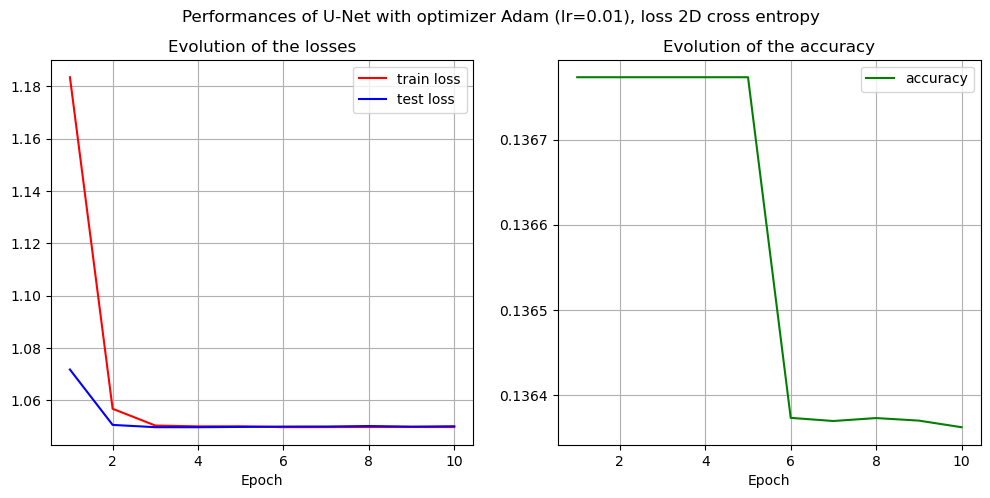

In [73]:
results_file_path = "./saving/results.pkl"
model_name = "U-Net"
optimizer_name = "Adam"
loss_name = "2D cross entropy"
learning_rate = 1e-2

plot_model_performances(results_file_path, 
                        model_name, optimizer_name, loss_name, 
                        learning_rate, 
                        save=True)

## Conclusion